In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
import random
import matplotlib.pyplot as plt
import numpy as np

random.seed(42)
np.random.seed(42)
cv2.setRNGSeed(42)

# Add the project directory to the Python path
sys.path.append('..')

# Import project modules
from src.preprocessing.image_loader import load_image_sequence, resize_images
from src.preprocessing.image_preprocessing import enhance_contrast

from src.feature_extraction.sift_extractor import extract_features_from_image_set
from src.feature_extraction.feature_matcher import match_image_pairs, filter_matches_on_black_background

from src.sfm.camera_calibration import estimate_camera_matrix
from src.sfm.pose_estimation import estimate_poses_incremental
from src.sfm.triangulation import triangulate_all_points, merge_triangulated_points
from src.sfm.bundle_adjustment import run_global_ba


from src.dense_reconstruction.dense_reconstruction import create_dense_reconstruction

from src.surface_reconstruction.surface_reconstruction import create_surface_mesh, smooth_mesh

from src.visualization.plot_matches import plot_feature_matching_analysis
from src.visualization.point_cloud_visualizer import plot_interactive_point_cloud, visualize_dense_point_cloud
from src.visualization.camera_visualizer import plot_interactive_camera_poses
from src.visualization.depth_map_visualizer import visualize_depth_maps
from src.visualization.mesh_visualizer import visualize_mesh_o3d

# Set up matplotlib for inline display
%matplotlib inline
# For newer matplotlib versions (3.6+)
plt.style.use('default')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.

Generating dense point cloud from depth maps...


In [ ]:
# Define configuration
config = {
    "preprocessing": {
        "resize_max_dimension": 1000,
        "enhance_contrast": True
    },
    "features": {
        "method": "sift",
        "max_features": 50000,
        "contrast_threshold": 0.01,
    },
    "matching": {
        "ratio_threshold": 0.75,
        "geometric_verification": True,
    },
    "calibration": {
        "focal_length_factor": 1.3,
    },
    "sfm": {
        "refine_poses": True,
        "min_angle_deg": 1.0,
        "max_reproj_error": 5.0,
        "iterations": 100,
        "merge_threshold": 0.05
    },
}

# Create output directory for results
output_dir = "results/"
os.makedirs(output_dir, exist_ok=True)

print("Configuration loaded")

Configuration loaded with 50,000 maximum features and strict quality filtering.


Loading black background images for feature extraction...
Loaded 36 black background images.
Resized images to maximum dimension of 1000 pixels.
Enhanced image contrast.


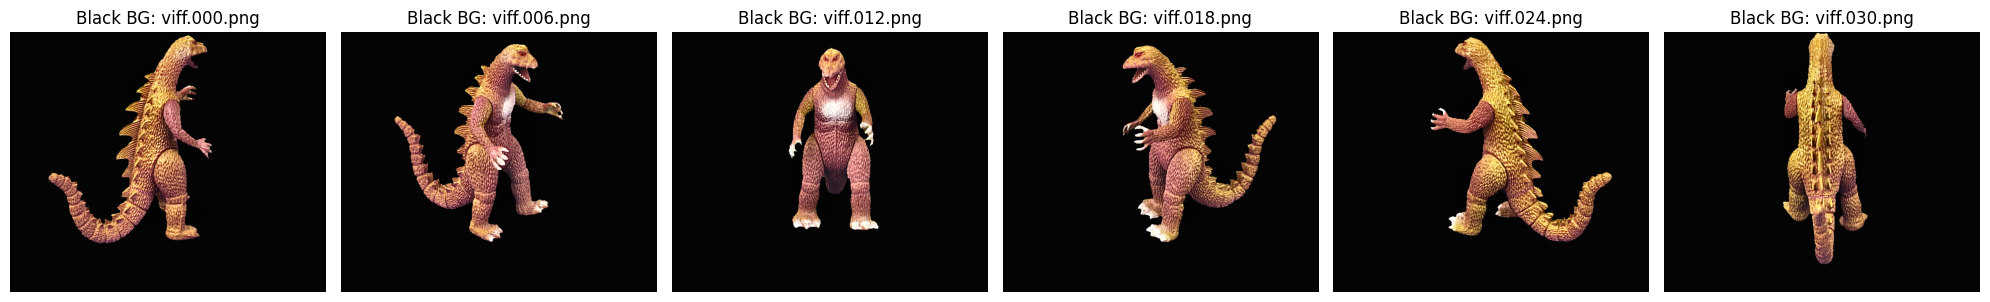

In [3]:
# Define paths to both datasets
dataset_path_black = 'data/dinosaur_cropped_black/'  # Black background

# Load black background images for feature extraction and matching
print("Loading black background images for feature extraction...")
black_images = load_image_sequence(dataset_path_black, pattern="viff.*.png")
print(f"Loaded {len(black_images)} black background images.")

# Resize black background images
max_dim = config['preprocessing']['resize_max_dimension']
black_images = resize_images(black_images, max_dimension=max_dim)
print(f"Resized images to maximum dimension of {max_dim} pixels.")

# Enhance contrast if specified
if config['preprocessing']['enhance_contrast']:
    black_images = enhance_contrast(black_images)
    print("Enhanced image contrast.")

# Display a comparison between black and original images
n_samples = 6 
step = len(black_images) // n_samples  # Sample every n-th image
fig, axes = plt.subplots(1, n_samples, figsize=(20, 5))

for i in range(n_samples):
    idx = i * step  
    if idx >= len(black_images):  
        break
        
    img_black, filename_black = black_images[idx]
    axes[i].imshow(img_black)
    axes[i].set_title(f"Black BG: {filename_black}")
    axes[i].axis('off')

# Add more spacing between subplots
plt.subplots_adjust(wspace=0.3)
plt.tight_layout()
plt.show()


Extracting comprehensive features from black background images...
Using SIFT extraction with target of 50000 features per image
viff.000.png: Extracted 17231 keypoints
viff.001.png: Extracted 17261 keypoints
viff.002.png: Extracted 17494 keypoints
viff.003.png: Extracted 17762 keypoints
viff.004.png: Extracted 17413 keypoints
viff.005.png: Extracted 16605 keypoints
viff.006.png: Extracted 16036 keypoints
viff.007.png: Extracted 15125 keypoints
viff.008.png: Extracted 14572 keypoints
viff.009.png: Extracted 13686 keypoints
viff.010.png: Extracted 12699 keypoints
viff.011.png: Extracted 12461 keypoints
viff.012.png: Extracted 12472 keypoints
viff.013.png: Extracted 12261 keypoints
viff.014.png: Extracted 12111 keypoints
viff.015.png: Extracted 12989 keypoints
viff.016.png: Extracted 13628 keypoints
viff.017.png: Extracted 15088 keypoints
viff.018.png: Extracted 16100 keypoints
viff.019.png: Extracted 16714 keypoints
viff.020.png: Extracted 16857 keypoints
viff.021.png: Extracted 17797 k

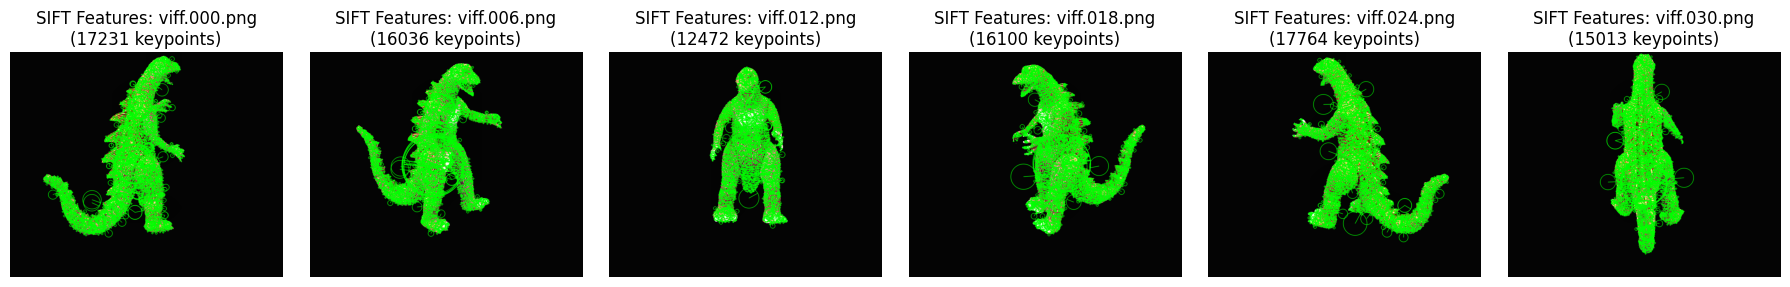

In [4]:
# Extract features from black background images with enhanced strategies
print("\nExtracting comprehensive features from black background images...")
feature_method = config['features']['method']
max_features = config['features']['max_features']  


print(f"Using SIFT extraction with target of {max_features} features per image")
features_dict = extract_features_from_image_set(black_images, method=feature_method, n_features=max_features, contrast_threshold=config['features']['contrast_threshold'])

# Print feature counts
total_features = 0
for filename, (keypoints, descriptors) in features_dict.items():
    print(f"{filename}: {len(keypoints)} keypoints")
    total_features += len(keypoints)
print(f"Total features extracted: {total_features} (avg {total_features/len(features_dict):.0f} per image)")

# Visualize keypoints on multiple sample images
n_samples = 6
step = len(black_images) // n_samples 
fig, axes = plt.subplots(1, 6, figsize=(18, 12))
axes = axes.flatten()  
for i in range(n_samples):
    idx = i * step  
    if idx >= len(black_images):
        break
    img, filename = black_images[idx]
    keypoints, _ = features_dict[filename]
    img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, 
                                         color=(0, 255, 0), 
                                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    axes[i].imshow(img_with_keypoints)
    axes[i].set_title(f"{feature_method.upper()} Features: {filename}\n({len(keypoints)} keypoints)")
    axes[i].axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()


Creating optimized view graph for circular object reconstruction...
Creating view graph for 36 images
Created 36 image pairs for matching
Filtered viff.000.png-viff.001.png: 2167 → 2106 matches
Filtered viff.001.png-viff.002.png: 2176 → 2142 matches
Filtered viff.002.png-viff.003.png: 2237 → 2193 matches
Filtered viff.003.png-viff.004.png: 2346 → 2316 matches
Filtered viff.004.png-viff.005.png: 2192 → 2161 matches
Filtered viff.005.png-viff.006.png: 1850 → 1830 matches
Filtered viff.006.png-viff.007.png: 1725 → 1702 matches
Filtered viff.007.png-viff.008.png: 1629 → 1616 matches
Filtered viff.008.png-viff.009.png: 1629 → 1609 matches
Filtered viff.009.png-viff.010.png: 1527 → 1514 matches
Filtered viff.010.png-viff.011.png: 1660 → 1640 matches
Filtered viff.011.png-viff.012.png: 1698 → 1684 matches
Filtered viff.012.png-viff.013.png: 1595 → 1581 matches
Filtered viff.013.png-viff.014.png: 1529 → 1519 matches
Filtered viff.014.png-viff.015.png: 1256 → 1247 matches
Filtered viff.015.png

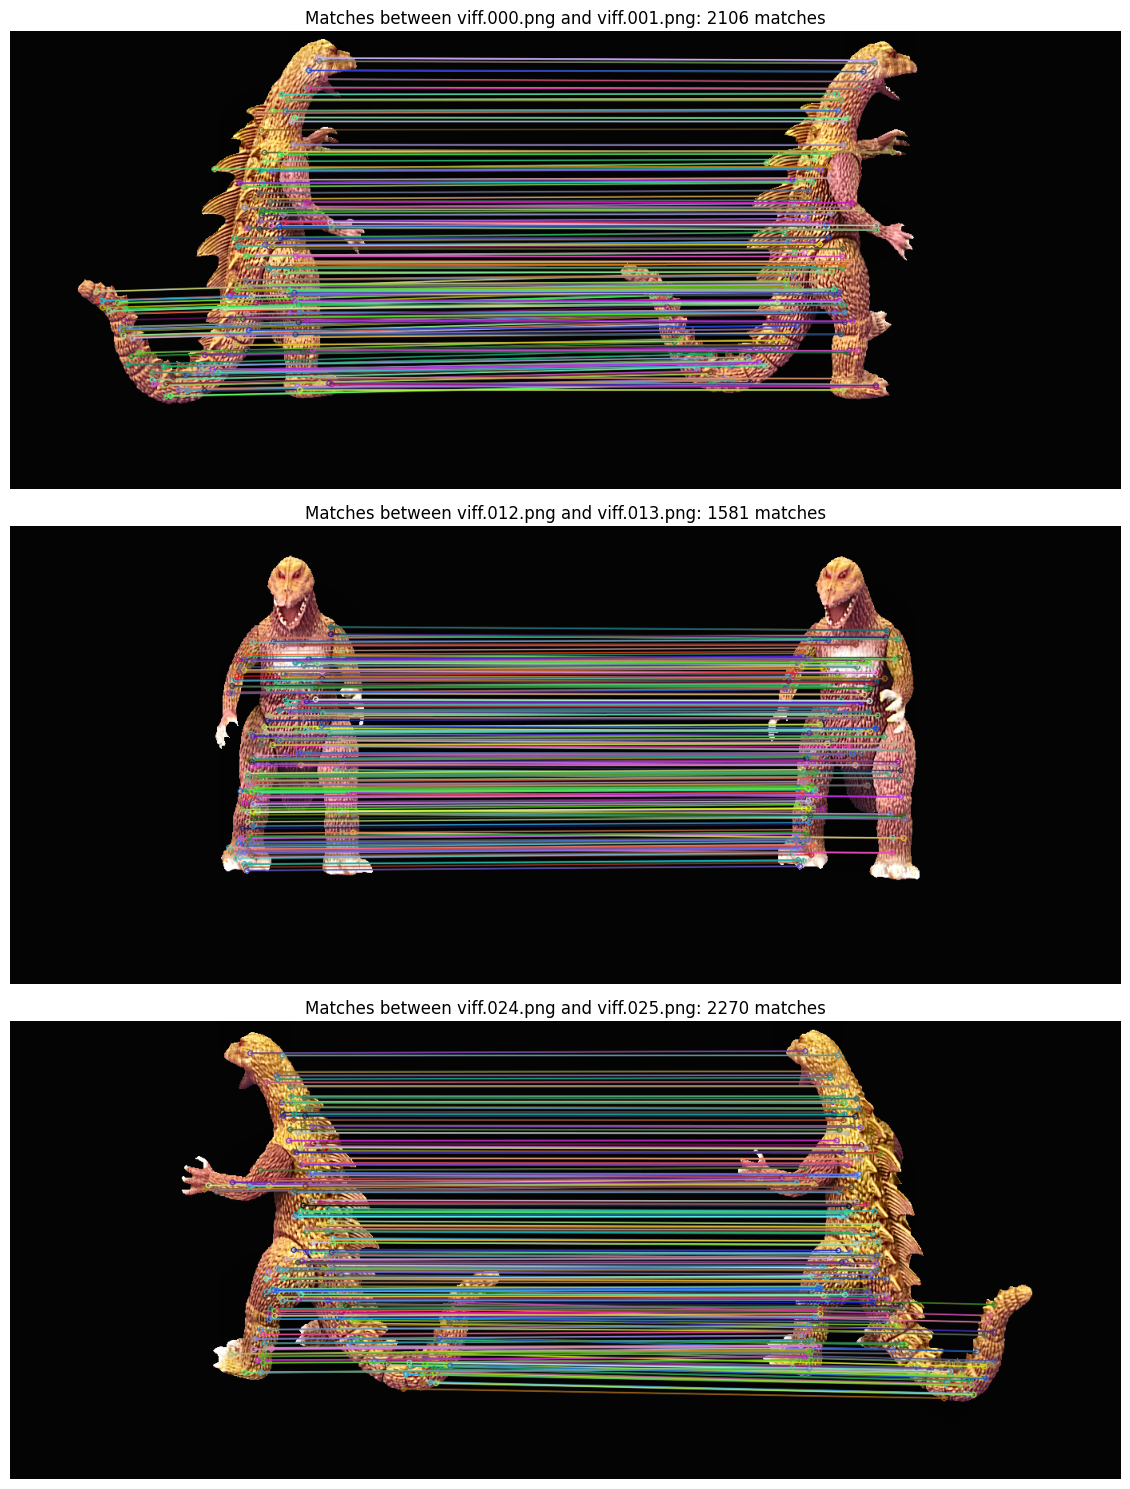

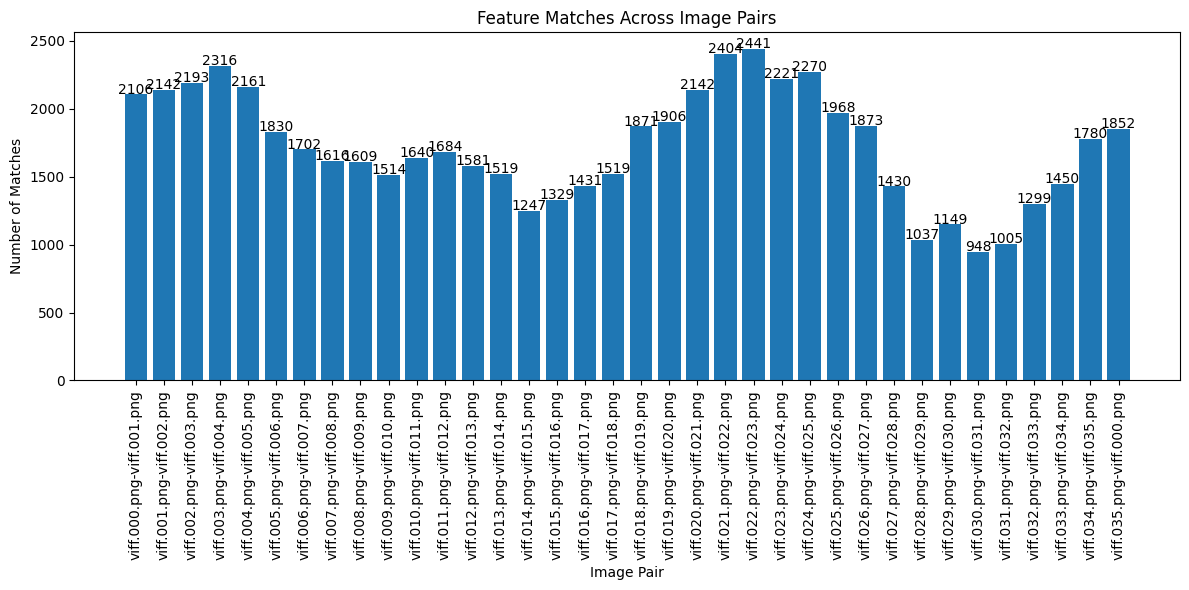

In [5]:
# Create image pairs for matching with a comprehensive circular strategy
print("\nCreating optimized view graph for circular object reconstruction...")
filenames = sorted([filename for _, filename in black_images], 
                  key=lambda x: int(''.join(filter(str.isdigit, x))))

# Number of images
n = len(filenames)
print(f"Creating view graph for {n} images")

# Create image pairs for matching with a comprehensive circular strategy
image_pairs = []

# 1. Keep sequential pairs as your foundation
for i in range(n-1):
    image_pairs.append((filenames[i], filenames[i+1]))
image_pairs.append((filenames[-1], filenames[0]))

# Remove duplicates while preserving order
seen = set()
image_pairs = [x for x in image_pairs if not (x in seen or seen.add(x))]

print(f"Created {len(image_pairs)} image pairs for matching")

# Match features, seed is important for reproducibility.
random.seed(47)
np.random.seed(47)
cv2.setRNGSeed(47)
matches_dict = match_image_pairs(
    features_dict, 
    image_pairs, 
    ratio_threshold=config['matching']['ratio_threshold'],
    geometric_verify=config['matching']['geometric_verification'],
)

#Filter to only keep matches found on the dinosaur.
matches_dict = filter_matches_on_black_background(matches_dict, black_images)

print(f"Successfully matched {len(matches_dict)} image pairs.")

# Display matches for multiple sample pairs
if len(matches_dict) > 0:
    num_pairs_to_show = 3
    all_pairs = list(matches_dict.keys())
    
    if len(all_pairs) >= num_pairs_to_show:
        step = max(1, len(all_pairs) // num_pairs_to_show)
        sample_pairs = [all_pairs[i] for i in range(0, len(all_pairs), step)[:num_pairs_to_show]]
    else:
        sample_pairs = all_pairs
    
    fig, axes = plt.subplots(len(sample_pairs), 1, figsize=(15, 5*len(sample_pairs)))
    if len(sample_pairs) == 1:
        axes = [axes] 
    
    for i, sample_pair in enumerate(sample_pairs):
        img1_name, img2_name = sample_pair
        kp1, kp2, matches = matches_dict[sample_pair]
        
        img1 = next(img for img, filename in black_images if filename == img1_name)
        img2 = next(img for img, filename in black_images if filename == img2_name)
        
        matches_to_draw = matches[:500] 
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches_to_draw, None,
                                     matchColor=(0, 255, 0), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        axes[i].imshow(img_matches)
        axes[i].set_title(f"Matches between {img1_name} and {img2_name}: {len(matches)} matches")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Show matching statistics across all pairs
    plot_feature_matching_analysis(matches_dict, figsize=(12, 6))

In [6]:
# Dictionary to store camera poses for each parameter combination
all_camera_poses = {}

# Estimate camera intrinsics (same for all runs)
sample_img, _ = black_images[0]
image_shape = sample_img.shape
focal_length_factor = config['calibration']['focal_length_factor']
focal_length = focal_length_factor * max(image_shape[0], image_shape[1])
K = estimate_camera_matrix(image_shape, focal_length)
print("Estimated camera matrix:")
print(K)

# Estimate camera poses
camera_poses = estimate_poses_incremental(matches_dict, K)

print(f"Estimated poses for {len(camera_poses)} cameras.")

# Show the interactive plot immediately for this parameter combination
print("Displaying interactive 3D plot...")
plot_interactive_camera_poses(camera_poses)

#Run global pose estimation with triangulation and merging.
if config['sfm']['refine_poses']:
    print("\nRunning bundle adjustment...")
    refined_poses, merged_points, _ = run_global_ba(camera_poses, matches_dict, K, iterations=config['sfm']['iterations']:)
    print("Bundle adjustment complete.")
    plot_interactive_camera_poses(refined_poses)

#Manually triangulate points and merge them without bundle adjustment.
else:
    # Triangulate 3D points
    print("\nTriangulating 3D points...")
    points_3d, point_observations = triangulate_all_points(camera_poses, matches_dict, K, min_angle_deg=config['sfm']['min_angle_deg'], max_reproj_error=config['sfm']['max_reproj_error'])

    print(f"Triangulated {len(points_3d)} 3D points.")

    # Merge close points to reduce noise
    merged_points, merged_observations = merge_triangulated_points(points_3d, point_observations, threshold=config['sfm']['merge_threshold'])
    print(f"After merging: {len(merged_points)} 3D points.")

# Visualize sparse point cloud
if len(merged_points) > 0:
    print("\nVisualizing sparse point cloud...")
    points_array = np.array(merged_points)
    
    # Assign random colors for visualization
    np.random.seed(42)  
    colors = np.random.rand(len(points_array), 3)
    
    # Interactive visualization
    plot_interactive_point_cloud(points_array, colors, title="Sparse 3D Reconstruction")

    # Save sparse point cloud
    sparse_cloud_file = os.path.join(output_dir, "/sparse_point_cloud/dinosaur_sparse.ply")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_array)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud(sparse_cloud_file, pcd)
    print(f"Saved sparse point cloud to {sparse_cloud_file}")


Estimated camera matrix:
[[903.5   0.  347.5]
 [  0.  903.5 286.5]
 [  0.    0.    1. ]]
Initializing with pair: viff.000.png and viff.001.png (2106 matches)
Triangulated 2106 initial points
Attempting to add image: viff.002.png
Found 244 2D-3D correspondences for viff.002.png
PnP successful with 135 inliers. Mean reprojection error: 0.39 pixels
Added pose for viff.002.png using 135 / 244 points
  Triangulated 949 new points with viff.001.png and viff.002.png
Attempting to add image: viff.003.png
Found 211 2D-3D correspondences for viff.003.png
PnP successful with 104 inliers. Mean reprojection error: 0.36 pixels
Added pose for viff.003.png using 104 / 211 points
  Triangulated 1065 new points with viff.002.png and viff.003.png
Attempting to add image: viff.004.png
Found 237 2D-3D correspondences for viff.004.png
PnP successful with 118 inliers. Mean reprojection error: 0.39 pixels
Added pose for viff.004.png using 118 / 237 points
  Triangulated 1066 new points with viff.003.png and v


Running bundle adjustment...
Triangulating from 36 camera poses and 36 feature matches
Found 36 valid image pairs for triangulation
Triangulated 61565 3D points
Merged 61565 points into 6571 points
Prepared 6571 points with at least 2 observations for bundle adjustment
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7449e+04                                    9.70e+04    
       1             21         4.7231e+04      2.18e+02       3.44e-01       9.57e+04    
       2             23         4.7213e+04      1.86e+01       8.97e-02       9.57e+04    
       3             24         4.7202e+04      1.06e+01       6.44e-02       9.58e+04    
       4             26         4.7200e+04      1.75e+00       2.30e-02       9.58e+04    
       5             28         4.7200e+04      1.88e-01       9.47e-03       9.58e+04    
       6             29         4.7200e+04      1.21e-04       1.69e-06       9.58e+04    
 


Visualizing sparse point cloud...


[Open3D WARNING] Write PLY failed: unable to open file: ..\data\results\sparse_point_cloud\dinosaur_sparse.ply
Saved sparse point cloud to ../data/results/sparse_point_cloud/dinosaur_sparse.ply



Creating dense reconstruction from sparse points...

Step 1: Generating depth maps...


Generating depth maps:   0%|          | 0/36 [00:00<?, ?it/s]


Processing view 1/36: viff.000.png
Propagating from 6165 sparse points...
Propagating depths to 35410 foreground pixels...


Generating depth maps:   3%|▎         | 1/36 [00:00<00:26,  1.31it/s]

Generated depth map for viff.000.png

Processing view 2/36: viff.001.png
Propagating from 6184 sparse points...
Propagating depths to 35609 foreground pixels...


Generating depth maps:   6%|▌         | 2/36 [00:01<00:24,  1.37it/s]

Generated depth map for viff.001.png

Processing view 3/36: viff.002.png
Propagating from 6170 sparse points...
Propagating depths to 36344 foreground pixels...


Generating depth maps:   8%|▊         | 3/36 [00:02<00:24,  1.35it/s]

Generated depth map for viff.002.png

Processing view 4/36: viff.003.png
Propagating from 6189 sparse points...
Propagating depths to 37584 foreground pixels...


Generating depth maps:  11%|█         | 4/36 [00:02<00:23,  1.37it/s]

Generated depth map for viff.003.png

Processing view 5/36: viff.004.png
Propagating from 6198 sparse points...
Propagating depths to 37576 foreground pixels...


Generating depth maps:  14%|█▍        | 5/36 [00:03<00:22,  1.37it/s]

Generated depth map for viff.004.png

Processing view 6/36: viff.005.png
Propagating from 6193 sparse points...
Propagating depths to 37192 foreground pixels...


Generating depth maps:  17%|█▋        | 6/36 [00:04<00:24,  1.23it/s]

Generated depth map for viff.005.png

Processing view 7/36: viff.006.png
Propagating from 6195 sparse points...
Propagating depths to 36398 foreground pixels...


Generating depth maps:  19%|█▉        | 7/36 [00:05<00:25,  1.15it/s]

Generated depth map for viff.006.png

Processing view 8/36: viff.007.png
Propagating from 6160 sparse points...
Propagating depths to 34790 foreground pixels...


Generating depth maps:  22%|██▏       | 8/36 [00:06<00:25,  1.10it/s]

Generated depth map for viff.007.png

Processing view 9/36: viff.008.png
Propagating from 6135 sparse points...
Propagating depths to 33518 foreground pixels...


Generating depth maps:  25%|██▌       | 9/36 [00:07<00:25,  1.05it/s]

Generated depth map for viff.008.png

Processing view 10/36: viff.009.png
Propagating from 6099 sparse points...
Propagating depths to 32878 foreground pixels...


Generating depth maps:  28%|██▊       | 10/36 [00:09<00:28,  1.10s/it]

Generated depth map for viff.009.png

Processing view 11/36: viff.010.png
Propagating from 6113 sparse points...
Propagating depths to 30387 foreground pixels...


Generating depth maps:  31%|███       | 11/36 [00:09<00:24,  1.02it/s]

Generated depth map for viff.010.png

Processing view 12/36: viff.011.png
Propagating from 6070 sparse points...
Propagating depths to 30642 foreground pixels...


Generating depth maps:  33%|███▎      | 12/36 [00:10<00:21,  1.12it/s]

Generated depth map for viff.011.png

Processing view 13/36: viff.012.png
Propagating from 6045 sparse points...
Propagating depths to 30746 foreground pixels...


Generating depth maps:  36%|███▌      | 13/36 [00:11<00:19,  1.18it/s]

Generated depth map for viff.012.png

Processing view 14/36: viff.013.png
Propagating from 6043 sparse points...
Propagating depths to 29758 foreground pixels...


Generating depth maps:  39%|███▉      | 14/36 [00:11<00:16,  1.31it/s]

Generated depth map for viff.013.png

Processing view 15/36: viff.014.png
Propagating from 6067 sparse points...
Propagating depths to 30371 foreground pixels...


Generating depth maps:  42%|████▏     | 15/36 [00:12<00:14,  1.42it/s]

Generated depth map for viff.014.png

Processing view 16/36: viff.015.png
Propagating from 6083 sparse points...
Propagating depths to 31657 foreground pixels...


Generating depth maps:  44%|████▍     | 16/36 [00:13<00:13,  1.48it/s]

Generated depth map for viff.015.png

Processing view 17/36: viff.016.png
Propagating from 6099 sparse points...
Propagating depths to 32961 foreground pixels...


Generating depth maps:  47%|████▋     | 17/36 [00:13<00:12,  1.54it/s]

Generated depth map for viff.016.png

Processing view 18/36: viff.017.png
Propagating from 6155 sparse points...
Propagating depths to 34617 foreground pixels...


Generating depth maps:  50%|█████     | 18/36 [00:14<00:11,  1.56it/s]

Generated depth map for viff.017.png

Processing view 19/36: viff.018.png
Propagating from 6187 sparse points...
Propagating depths to 35808 foreground pixels...


Generating depth maps:  53%|█████▎    | 19/36 [00:14<00:11,  1.50it/s]

Generated depth map for viff.018.png

Processing view 20/36: viff.019.png
Propagating from 6184 sparse points...
Propagating depths to 35839 foreground pixels...


Generating depth maps:  56%|█████▌    | 20/36 [00:15<00:11,  1.38it/s]

Generated depth map for viff.019.png

Processing view 21/36: viff.020.png
Propagating from 6170 sparse points...
Propagating depths to 35904 foreground pixels...


Generating depth maps:  58%|█████▊    | 21/36 [00:16<00:12,  1.19it/s]

Generated depth map for viff.020.png

Processing view 22/36: viff.021.png
Propagating from 6165 sparse points...
Propagating depths to 36724 foreground pixels...


Generating depth maps:  61%|██████    | 22/36 [00:17<00:12,  1.12it/s]

Generated depth map for viff.021.png

Processing view 23/36: viff.022.png
Propagating from 6188 sparse points...
Propagating depths to 37612 foreground pixels...


Generating depth maps:  64%|██████▍   | 23/36 [00:18<00:10,  1.19it/s]

Generated depth map for viff.022.png

Processing view 24/36: viff.023.png
Propagating from 6206 sparse points...
Propagating depths to 37309 foreground pixels...


Generating depth maps:  67%|██████▋   | 24/36 [00:19<00:09,  1.23it/s]

Generated depth map for viff.023.png

Processing view 25/36: viff.024.png
Propagating from 6198 sparse points...
Propagating depths to 36066 foreground pixels...


Generating depth maps:  69%|██████▉   | 25/36 [00:20<00:08,  1.25it/s]

Generated depth map for viff.024.png

Processing view 26/36: viff.025.png
Propagating from 6167 sparse points...
Propagating depths to 34572 foreground pixels...


Generating depth maps:  72%|███████▏  | 26/36 [00:20<00:07,  1.33it/s]

Generated depth map for viff.025.png

Processing view 27/36: viff.026.png
Propagating from 6157 sparse points...
Propagating depths to 33724 foreground pixels...


Generating depth maps:  75%|███████▌  | 27/36 [00:21<00:06,  1.42it/s]

Generated depth map for viff.026.png

Processing view 28/36: viff.027.png
Propagating from 6147 sparse points...
Propagating depths to 34132 foreground pixels...


Generating depth maps:  78%|███████▊  | 28/36 [00:22<00:05,  1.48it/s]

Generated depth map for viff.027.png

Processing view 29/36: viff.028.png
Propagating from 6149 sparse points...
Propagating depths to 33775 foreground pixels...


Generating depth maps:  81%|████████  | 29/36 [00:22<00:04,  1.54it/s]

Generated depth map for viff.028.png

Processing view 30/36: viff.029.png
Propagating from 6112 sparse points...
Propagating depths to 33234 foreground pixels...


Generating depth maps:  83%|████████▎ | 30/36 [00:23<00:04,  1.46it/s]

Generated depth map for viff.029.png

Processing view 31/36: viff.030.png
Propagating from 6113 sparse points...
Propagating depths to 32689 foreground pixels...


Generating depth maps:  86%|████████▌ | 31/36 [00:24<00:03,  1.48it/s]

Generated depth map for viff.030.png

Processing view 32/36: viff.031.png
Propagating from 6093 sparse points...
Propagating depths to 32303 foreground pixels...


Generating depth maps:  89%|████████▉ | 32/36 [00:24<00:02,  1.52it/s]

Generated depth map for viff.031.png

Processing view 33/36: viff.032.png
Propagating from 6122 sparse points...
Propagating depths to 32029 foreground pixels...


Generating depth maps:  92%|█████████▏| 33/36 [00:25<00:01,  1.54it/s]

Generated depth map for viff.032.png

Processing view 34/36: viff.033.png
Propagating from 6106 sparse points...
Propagating depths to 32265 foreground pixels...


Generating depth maps:  94%|█████████▍| 34/36 [00:25<00:01,  1.56it/s]

Generated depth map for viff.033.png

Processing view 35/36: viff.034.png
Propagating from 6097 sparse points...
Propagating depths to 33902 foreground pixels...


Generating depth maps:  97%|█████████▋| 35/36 [00:26<00:00,  1.55it/s]

Generated depth map for viff.034.png

Processing view 36/36: viff.035.png
Propagating from 6192 sparse points...
Propagating depths to 35137 foreground pixels...


Generating depth maps: 100%|██████████| 36/36 [00:27<00:00,  1.32it/s]


Generated depth map for viff.035.png

Step 2: Creating dense point cloud...


Backprojecting depth maps: 100%|██████████| 36/36 [00:00<00:00, 191.10it/s]

Generated 35410 points from viff.000.png
Generated 35609 points from viff.001.png
Generated 36344 points from viff.002.png
Generated 37584 points from viff.003.png
Generated 37576 points from viff.004.png
Generated 37192 points from viff.005.png
Generated 36398 points from viff.006.png
Generated 34788 points from viff.007.png
Generated 32917 points from viff.008.png
Generated 31928 points from viff.009.png
Generated 30062 points from viff.010.png
Generated 29672 points from viff.011.png
Generated 29013 points from viff.012.png
Generated 28380 points from viff.013.png
Generated 28805 points from viff.014.png
Generated 28603 points from viff.015.png
Generated 31777 points from viff.016.png
Generated 34519 points from viff.017.png
Generated 35808 points from viff.018.png
Generated 35839 points from viff.019.png
Generated 35904 points from viff.020.png
Generated 36724 points from viff.021.png
Generated 37612 points from viff.022.png
Generated 37309 points from viff.023.png
Generated 36066 

Combined point cloud has 1219481 points
Saved raw dense point cloud to ../data/results/dense_point_cloud\dense_raw.ply
Downsampling point cloud...
Downsampled to 1004209 points
Removing outliers...
After outlier removal: 937871 points
Saved clean dense point cloud to ../data/results/dense_point_cloud\dense_clean.ply


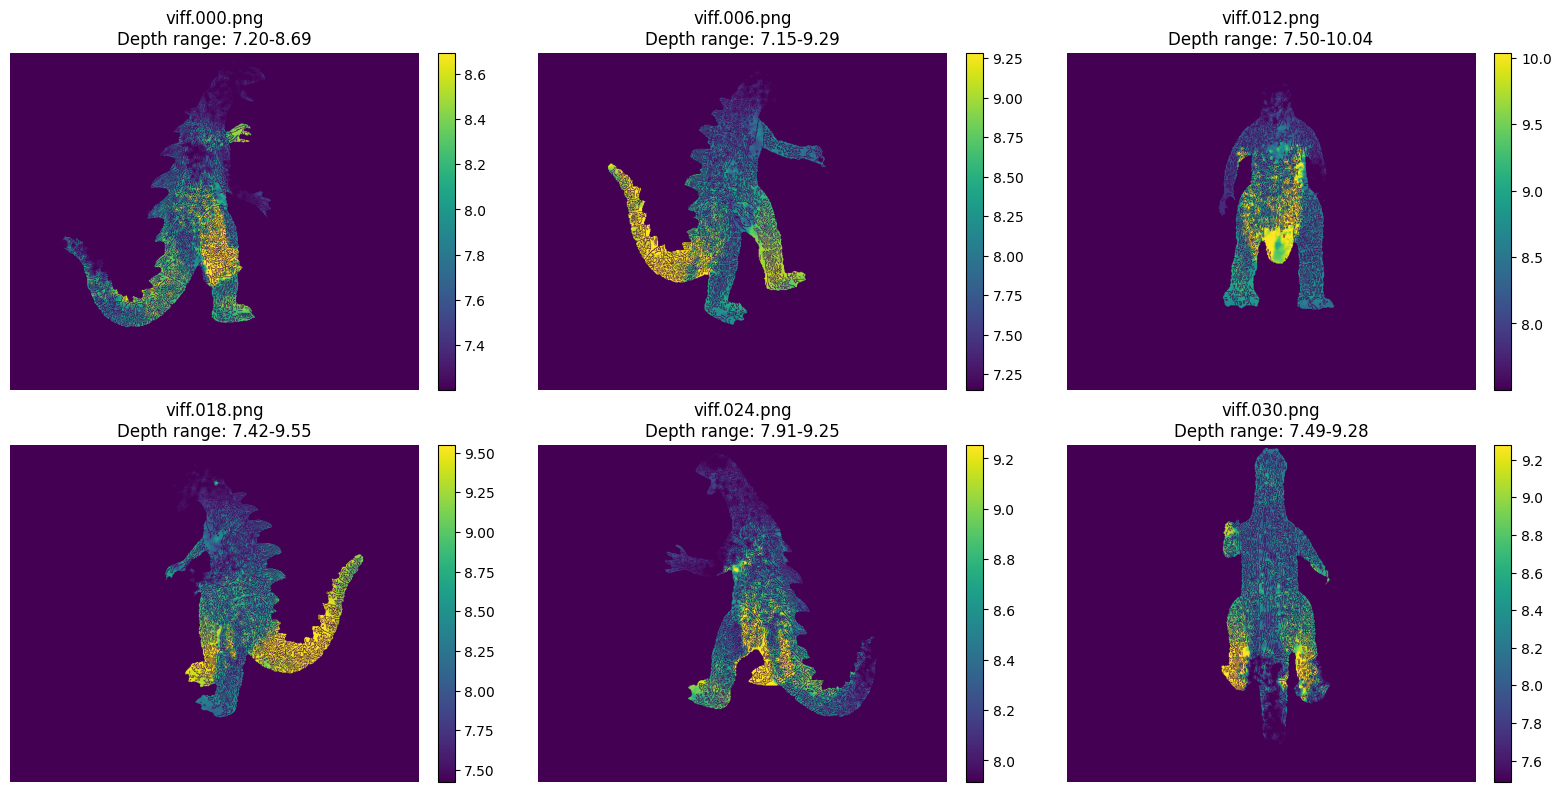

Showing 6 of 36 valid depth maps (from 36 total)
Visualizing point cloud with 937,871 points

Visualization window opened!
Controls:
  Left-click + drag: Rotate
  Right-click + drag: Pan
  Mouse wheel/middle-click + drag: Zoom
  'h': Show help message with all controls
  '-/+': Decrease/increase point size
  'r': Reset view
  'c': Change background color
  'q': Close window
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Forespurt transformeringsoperasjon er ikke støttet. 


In [7]:
dense_results = create_dense_reconstruction(
    points_array, colors, black_images, camera_poses, K, output_dir)

visualize_depth_maps(dense_results['depth_maps'], num_samples=6)

# Assign random colors for visualization
np.random.seed(42)  
colors = np.random.rand(len(points_array), 3)

# Interactive visualization
dense_points = np.asarray(dense_results["point_cloud"].points)
#serve_point_cloud(dense_results["point_cloud"], colors, title="Dense 3D Reconstruction")
visualize_dense_point_cloud(
    dense_results["point_cloud"],     # Pass the Open3D point cloud directly
    window_title="Dense 3D Reconstruction",
    width=1280,
    height=720
)


In [8]:
# Surface Mesh Generation from Dense Point Cloud
print("\nGenerating surface meshes from dense point cloud using poisson...")
    
poisson_mesh = create_surface_mesh(dense_results['point_cloud'], output_dir)

visualize_mesh_o3d(poisson_mesh, window_name="Poisson Mesh")


Generating surface meshes from dense point cloud using poisson...
Estimating normals...
Performing Poisson surface reconstruction...
Removing low-density vertices...
Cleaning mesh...
[Open3D WARNING] Write Ply clamped color value to valid range
Saved Poisson mesh to ../data/results/dense_mesh\dense_poisson.ply


In [ ]:
smoothed_mesh = smooth_mesh(
    poisson_mesh, 
    method="taubin",
    iterations=15
)

visualize_mesh_o3d(smoothed_mesh, window_name="Smoothed Mesh")

smoothed_mesh = smooth_mesh(
    smoothed_mesh, 
    method="subdivision",
    iterations=1
)

visualize_mesh_o3d(smoothed_mesh, window_name="Smoothed Mesh")

Applying Taubin smoothing (15 iterations, lambda=0.5, mu=-0.53)
